In [1]:
%matplotlib widget

In [2]:
import numpy
import pyFAI
from pyFAI.test.utilstest import UtilsTest
import fabio
from pyFAI.gui import jupyter
from pyFAI import units
from pyFAI.method_registry import Method,IntegrationMethod

<Axes: >

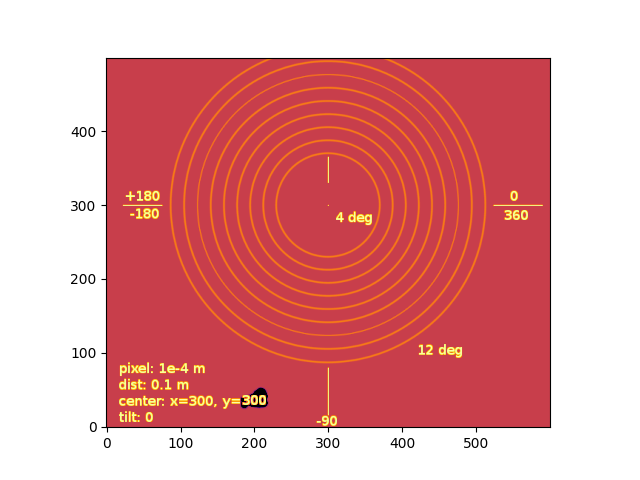

In [3]:
img = fabio.open(UtilsTest.getimage("moke.tif")).data
jupyter.display(img)

In [4]:
det = pyFAI.detector_factory("Detector", {"pixel1":1e-4,"pixel2":1e-4})
ai = pyFAI.load({"detector": det, "wavelength": 1e-10})
ai.setFit2D(100, 300, 300)
ai

/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 3.000000e-02, 3.000000e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=300.000, y=300.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å

In [5]:
len(IntegrationMethod.select_method(dim=2))

54

In [6]:
for m in IntegrationMethod.select_method(dim=2):
    print(m, end="")
    if m.algorithm=="histogram" and m.target is not None: 
        print("OpenCL histogram skipped")
        continue
    try:
        res = ai.integrate2d(img, 400,400, method=m, unit=("qx_nm^-1","qy_nm^-1"))
    except:
        print("broken")
    else:    
        print(f"{res[1].min():.2f}<qx<{res[1].max():.2f}, {res[2].min():.2f}<qy<{res[2].max():.2f} <I>={numpy.nanmean(res[0]):.2f} ± {numpy.nanstd(res[0]):.2f}")

IntegrationMethod(2d int, no split, histogram, python)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, no split, histogram, cython)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, bbox split, histogram, cython)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, full split, histogram, cython)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, pseudo split, histogram, cython)-18.20<qx<18.20, -18.21<qy<12.34 <I>=2.44 ± 13.72
IntegrationMethod(2d int, no split, CSR, cython)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, bbox split, CSR, cython)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, no split, CSR, python)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, bbox split, CSR, python)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, no split, CSC, cython)-18.17<qx<18.17, -18

/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, no split, CSR, OpenCL, Intel(R) OpenCL / AMD EPYC 7262 8-Core Processor)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, bbox split, CSR, OpenCL, AMD Accelerated Parallel Processing / gfx900:xnack-)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, no split, CSR, OpenCL, AMD Accelerated Parallel Processing / gfx900:xnack-)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, full split, CSR, OpenCL, NVIDIA CUDA / NVIDIA GeForce GTX 750 Ti)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, full split, CSR, OpenCL, NVIDIA CUDA / NVIDIA GeForce GT 1030)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, full split, CSR, OpenCL, Portable Computing Language / pthread-haswell-AMD EPYC 7262 8-Core Processor)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, full spl

IntegrationMethod(2d int, full split, CSR, cython)


<Axes: xlabel='Rectilinear scattering vector $q_x$ ($nm^{-1}$)', ylabel='Rectilinear scattering vector $q_y$ ($nm^{-1}$)'>

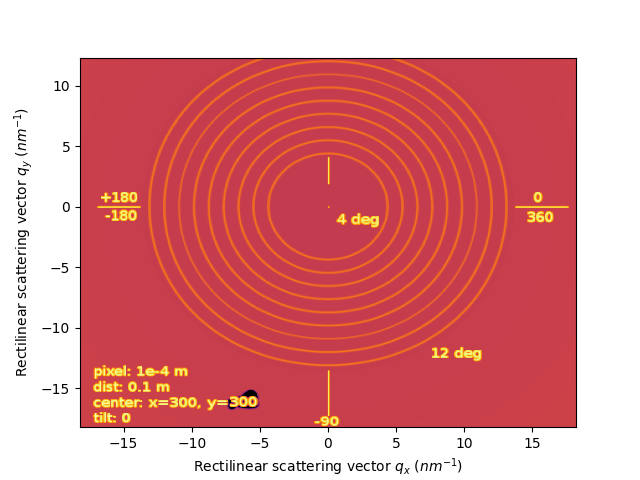

In [7]:
m = IntegrationMethod.select_method(dim=2, split="full", algo="CSR")[0]
print(m)
ai.reset()
res = ai.integrate2d(img, 400,400, method=m, unit=("qx_nm^-1", "qy_nm^-1"))
jupyter.plot2d(res)

In [8]:
ai._cached_array.keys()

dict_keys(['cos_incidence', 'solid_angle#3.0_crc', 'solid_angle#3.0', 'qx_corner', 'qy_corner'])